In [19]:
%load_ext autoreload
%autoreload 2

import os
import time

import sys
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
sys.path.append('/oasis/projects/nsf/csd181/yuncong/opencv-2.4.9/release/lib/python2.7/site-packages')
import cv2

In [21]:
from joblib import Parallel, delayed

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
from skimage.filters.rank import entropy
from skimage.morphology import remove_small_objects, disk, remove_small_holes
from skimage.measure import label, regionprops
from skimage.color import rgb2gray
from skimage.io import imread, imsave
from skimage.segmentation import active_contour
from skimage.filters import gaussian
from skimage.filter import threshold_adaptive
from skimage.util import img_as_ubyte

In [24]:
from sklearn.mixture import GaussianMixture

In [25]:
from sklearn.cluster import KMeans

In [26]:
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))

In [27]:
from annotation_utilities import points_inside_contour

In [28]:
from registration_utilities import find_contour_points

In [29]:
# clf = clfs[np.argsort(bics)[0]]

# covars = np.atleast_1d(np.squeeze(clf.covariances_))

# means = np.atleast_1d(np.squeeze(clf.means_))
# order = np.argsort(means)
# weights = clf.weights_

# counts, bins = np.histogram(e.flat, bins=100, density=True);
# gs = np.array([w * 1./np.sqrt(2*np.pi*c) * np.exp(-(bins-m)**2/(2*c)) for m, c, w in zip(means, covars, weights)])

# plt.figure();
# plt.title('fitted guassians');
# plt.plot(bins, gs.T);

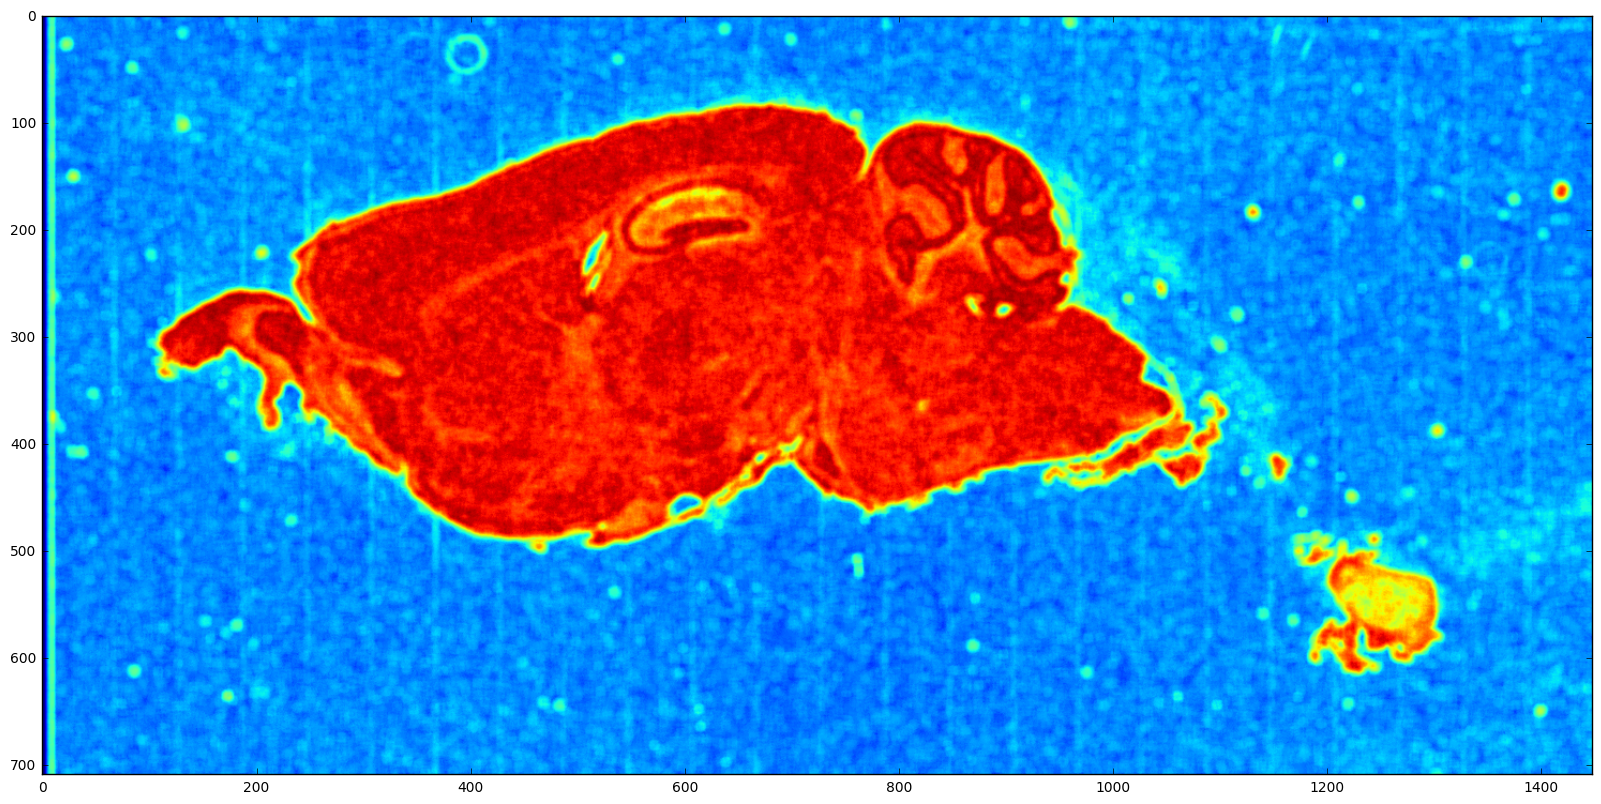

num. components 3
3.21968496446


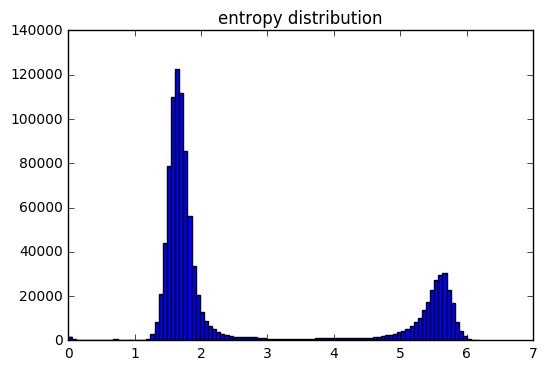

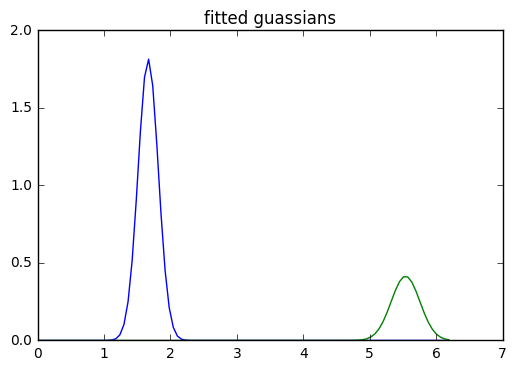

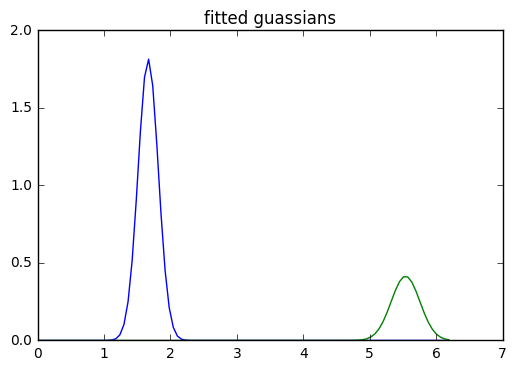

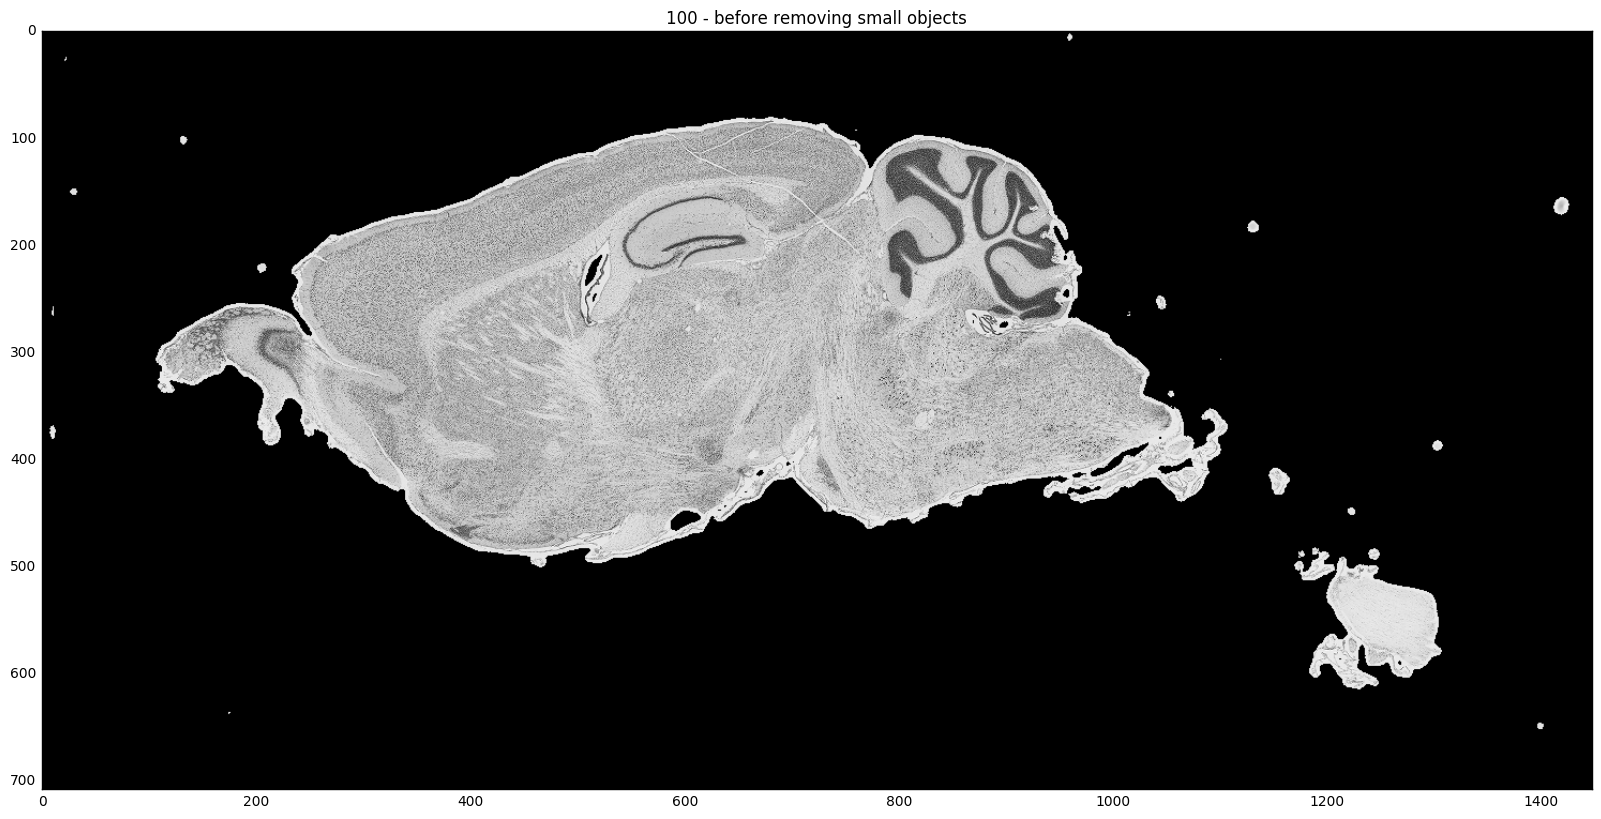

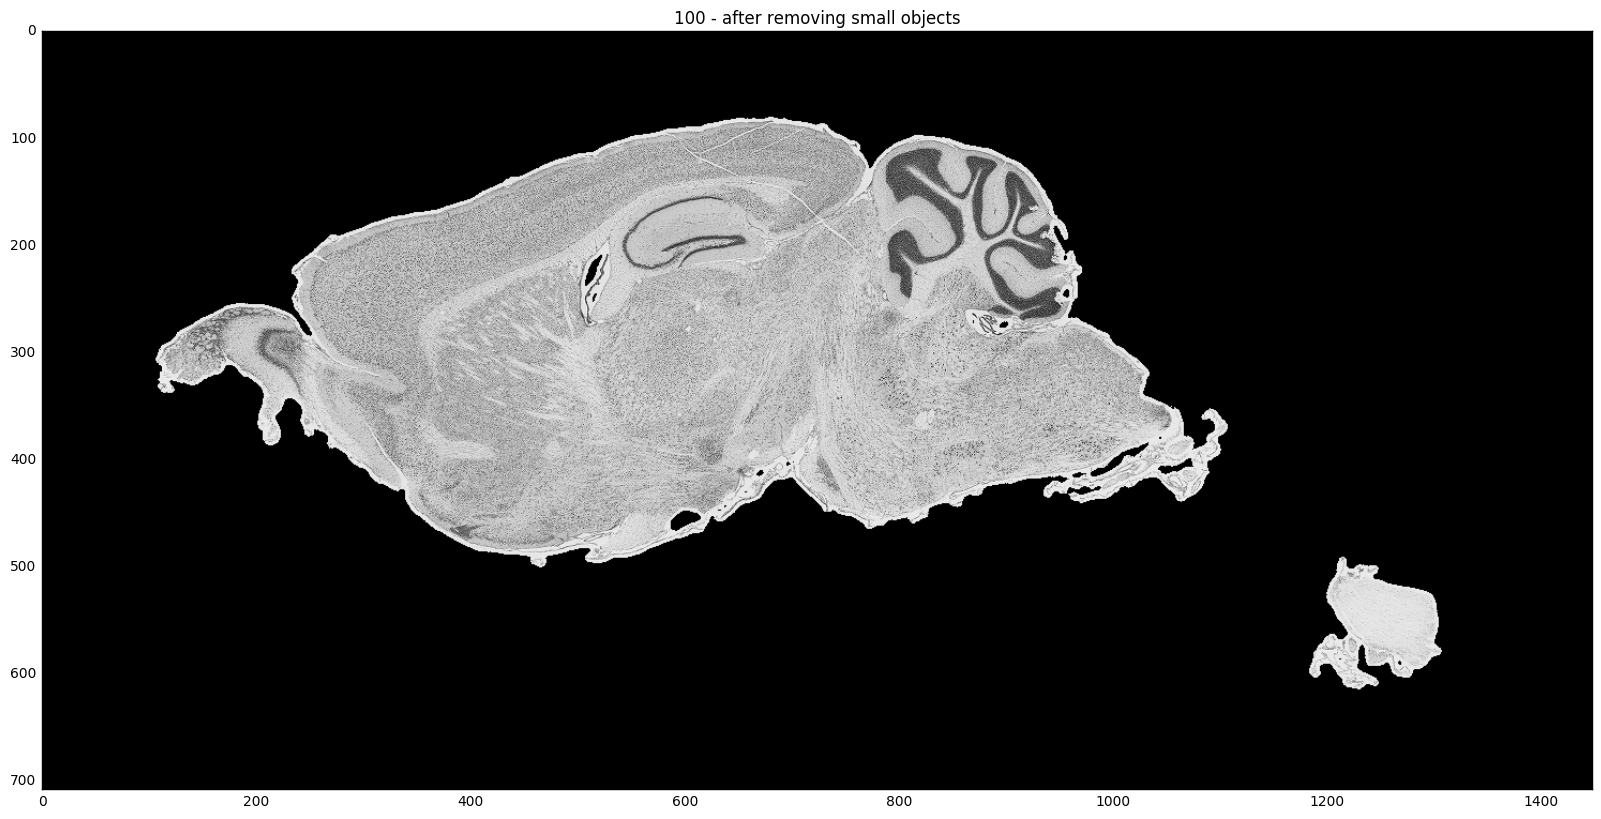

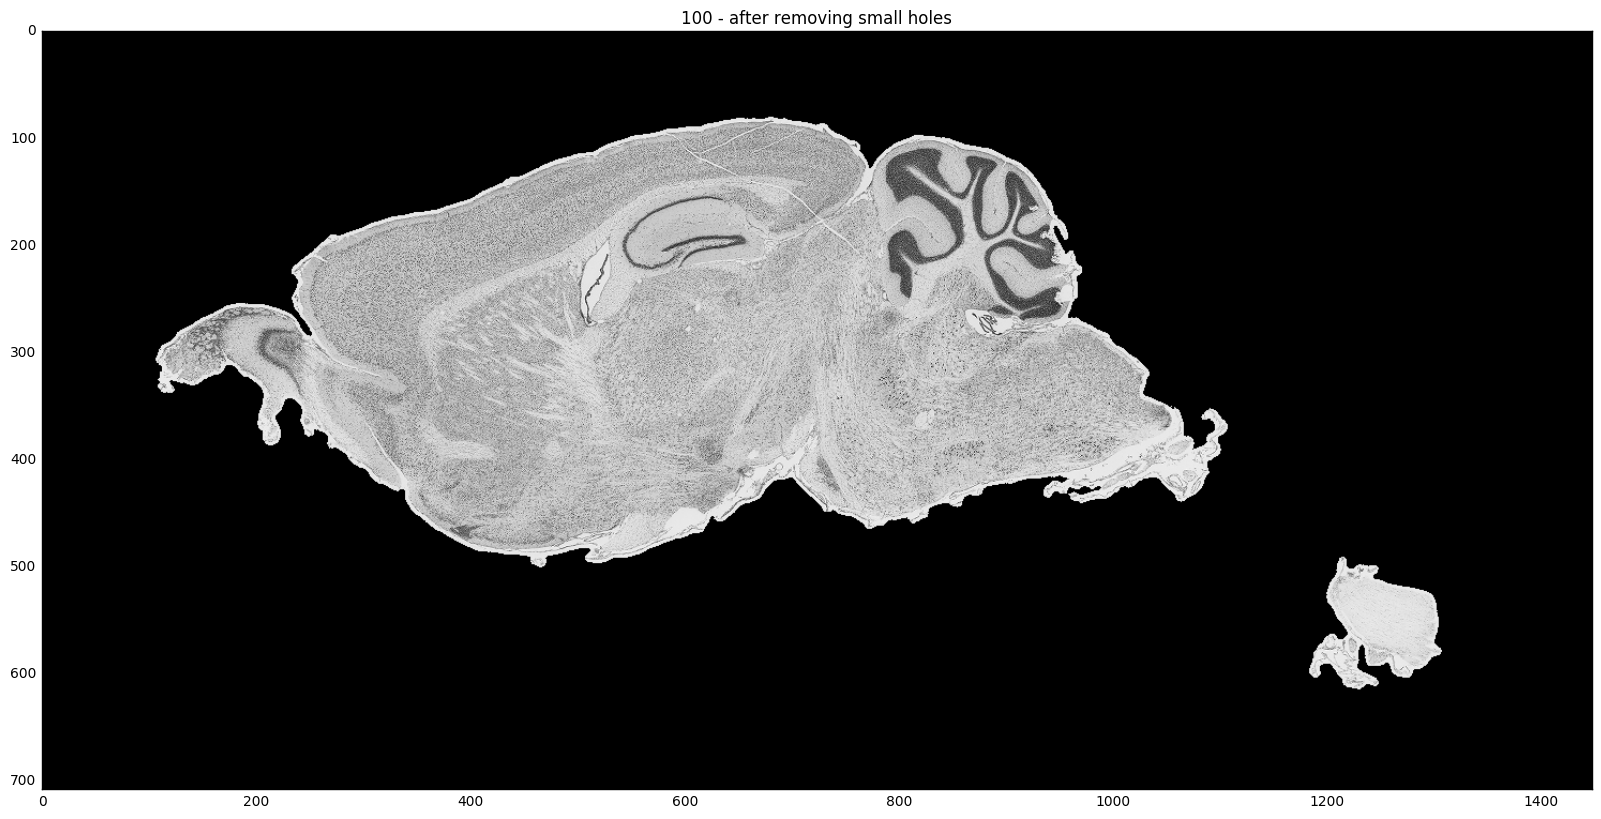

In [37]:
s = 100

fn = 'MD599-N62-2015.10.05-12.24.58_MD599_1_0184'
stack = 'MD599'

img_rgb = imread('/home/yuncong/CSHL_data/%(stack)s/%(fn)s.tif' % dict(stack=stack, fn=fn))
img = rgb2gray(img_rgb)

h, w = img.shape
e = entropy(img, disk(5))

plt.figure(figsize=(20,20));
plt.imshow(e);
plt.show();


plt.figure();
plt.title('entropy distribution');
plt.hist(e.flatten(), bins=100);

x = np.atleast_2d(e[e > .1]).T

bics = []
clfs = []
# for nc in [3]:
for nc in [2,3]:
# for nc in [2]:
    clf = GaussianMixture(n_components=nc, covariance_type='full')
    clf.fit(x)
    bic = clf.bic(x)
    bics.append(bic)
    clfs.append(clf)
    
print 'num. components', [2,3][np.argsort(bics)[0]]

clf = clfs[np.argsort(bics)[0]]

covars = np.atleast_1d(np.squeeze(clf.covariances_))


if clf.n_components == 3:
    invalid_component = np.where(covars > .4)[0]
    if len(invalid_component) == 1:
        valid_components = [i for i in range(3) if i != invalid_component]
    else:
        assert len(invalid_component) == 0
        valid_components = range(clf.n_components)
        
covars = np.atleast_1d(np.squeeze(clf.covariances_))[valid_components]        
means = np.atleast_1d(np.squeeze(clf.means_))[valid_components]
weights = clf.weights_[valid_components]

counts, bins = np.histogram(e.flat, bins=100, density=True);
gs = np.array([w * 1./np.sqrt(2*np.pi*c) * np.exp(-(bins-m)**2/(2*c)) for m, c, w in zip(means, covars, weights)])

plt.figure();
plt.title('fitted guassians');
plt.plot(bins, gs.T);


new_means = []
new_covs = []
new_weights = []

# Force into 2 classes: foreground and background
km = KMeans(2)
km.fit([[x]for x in means])
for l in set(km.labels_):
    new_mean = means[km.labels_ == l].mean()
    new_cov = covars[km.labels_ == l].mean()
    new_weight = weights[km.labels_ == l].sum()
    
    new_means.append(new_mean)
    new_covs.append(new_cov)
    new_weights.append(new_weight)

order = np.argsort(new_means)
new_means = np.array(new_means)[order]
new_covs = np.array(new_covs)[order]
new_weights = np.array(new_weights)[order]

counts, bins = np.histogram(e.flat, bins=100, density=True);

# ignore small components
gs = np.array([w * 1./np.sqrt(2*np.pi*c) * np.exp(-(bins-m)**2/(2*c)) for m, c, w in zip(new_means, new_covs, new_weights)])

plt.figure();
plt.title('fitted guassians');
plt.plot(bins, gs.T);

thresh = bins[np.where(gs[-1] - gs[-2] < 0)[0][-1]]
# thresh = 4
print thresh

mask = e > thresh


img2 = img.copy()
img2[~mask] = 0

plt.figure(figsize=(20,20));
plt.imshow(img2, cmap=plt.cm.gray);
plt.title('%d - before removing small objects' % s);
plt.show();


component_areas = [p.area for p in regionprops(label(mask))]
max_area = np.max(component_areas)
min_size = min(max_area, 5000)

mask_rso = remove_small_objects(mask, min_size=min_size, connectivity=8)

img2 = img.copy()
img2[~mask_rso] = 0
plt.figure(figsize=(20,20));
plt.imshow(img2, cmap=plt.cm.gray);
plt.title('%d - after removing small objects' % s);
plt.show();


mask_rsh = remove_small_holes(mask_rso, min_size=20000, connectivity=8)

img2 = img.copy()
img2[~mask_rsh] = 0
plt.figure(figsize=(20,20));
plt.imshow(img2, cmap=plt.cm.gray);
plt.title('%d - after removing small holes' % s);
plt.show();

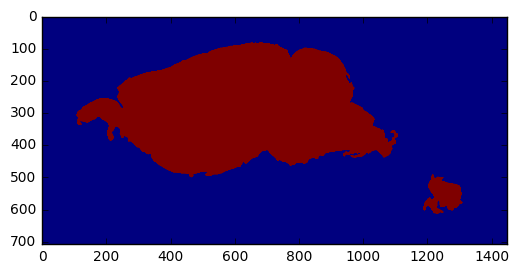

In [38]:
entropy_mask = mask_rsh
plt.imshow(entropy_mask);

In [39]:
init_contours = [xys for xys in find_contour_points(entropy_mask.astype(np.int), sample_every=1)[1] if len(xys) > 50]

# assert len(init_contours) > 0, 'No contour is detected from entropy mask %s' % fn
print len(init_contours)

img_adap = threshold_adaptive(img, 51)
img_adap[~entropy_mask] = 1

2


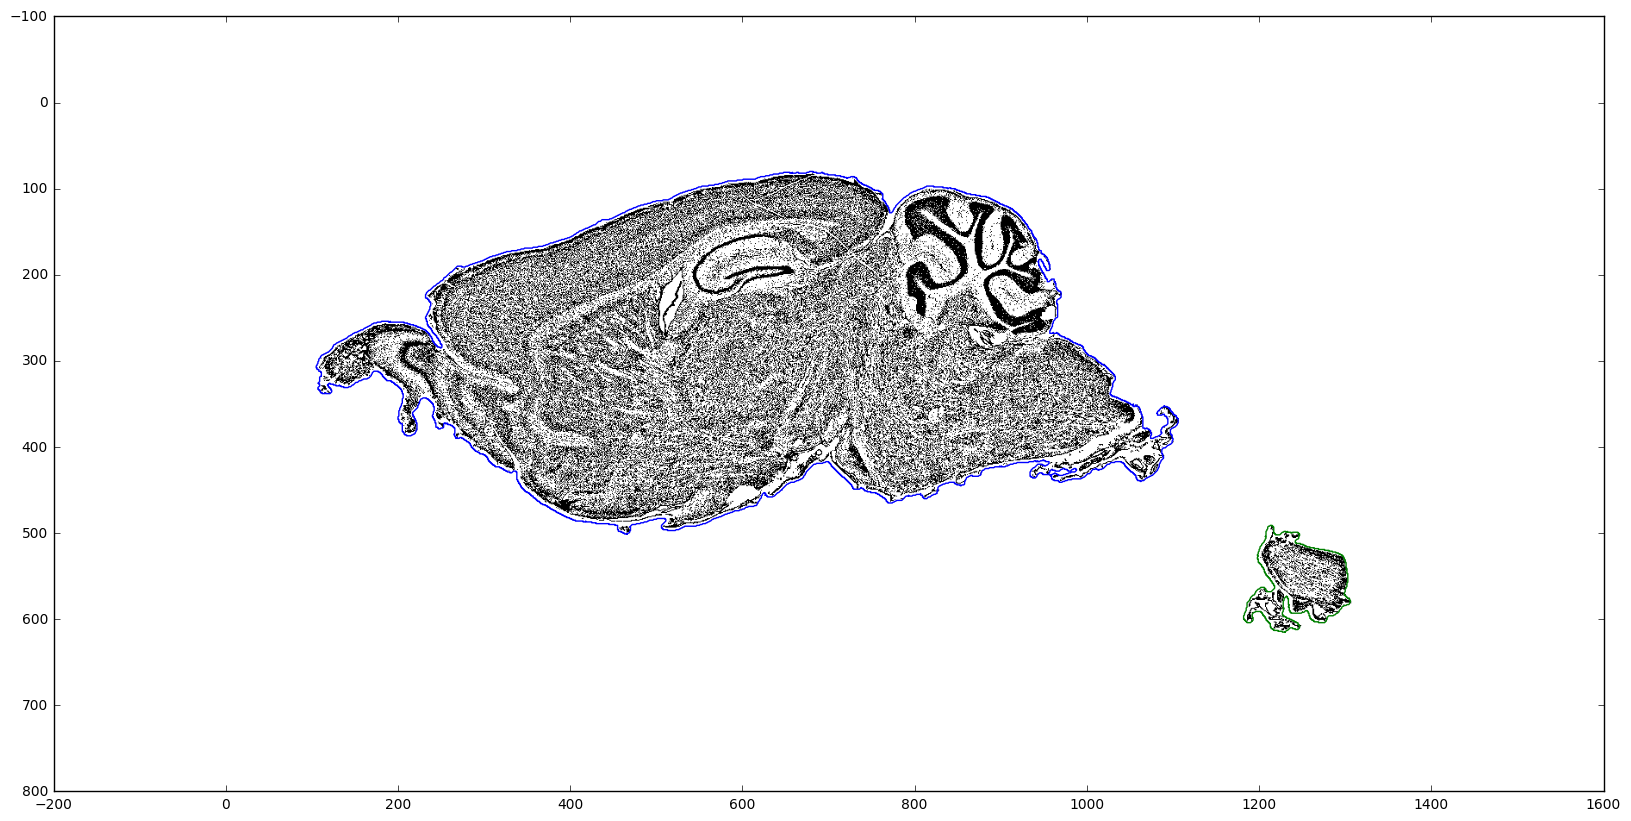

In [40]:
plt.figure(figsize=(20,20));
plt.imshow(img_adap, cmap=plt.cm.gray)
for cnt in init_contours:
    plt.plot(cnt[:,0], cnt[:,1])
plt.show();

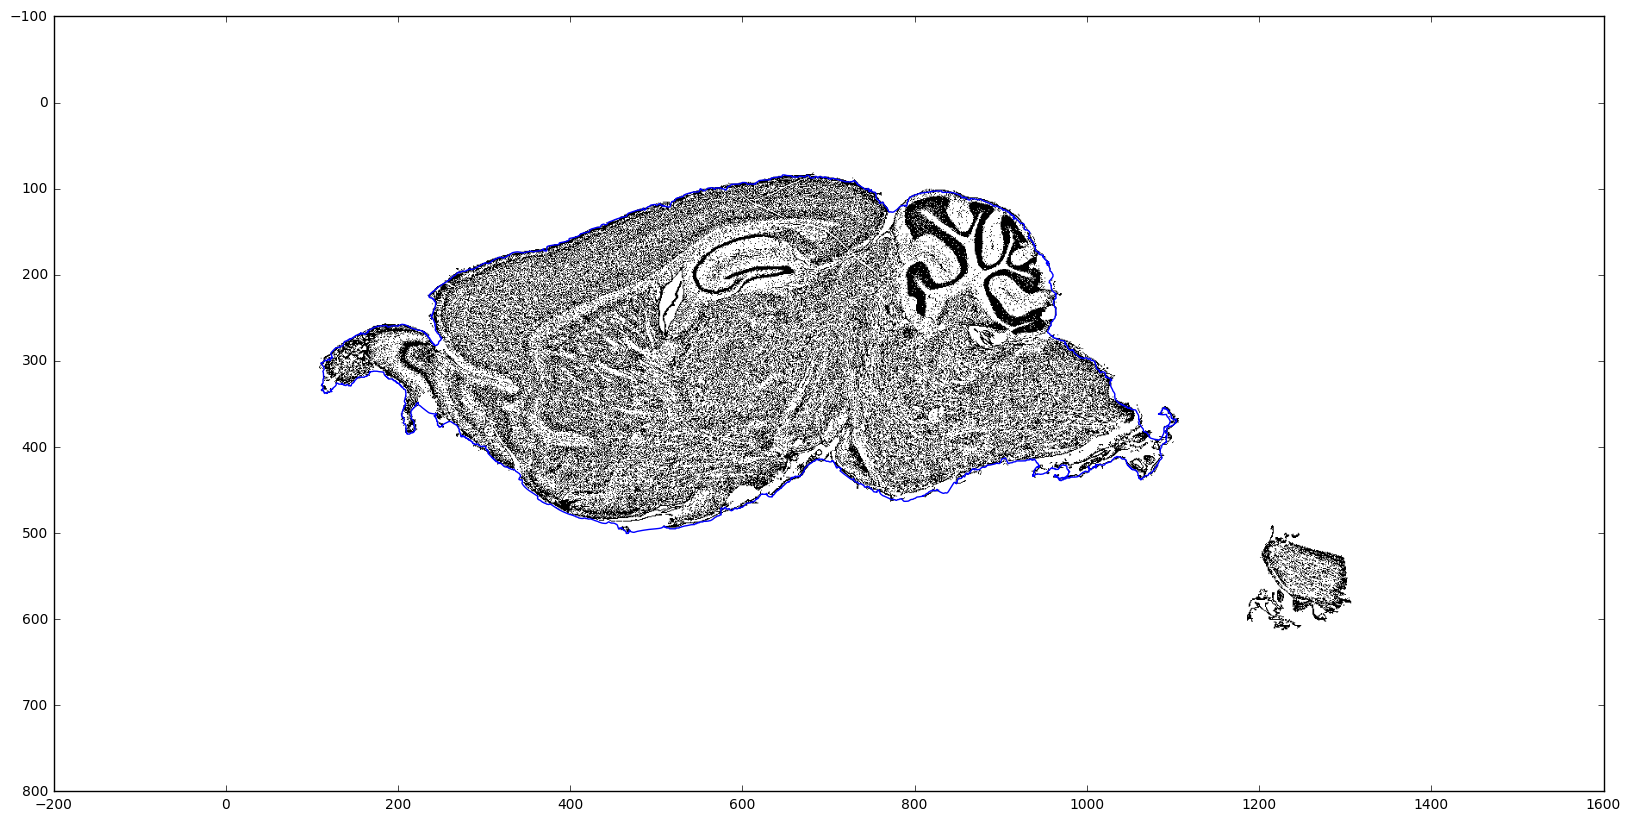

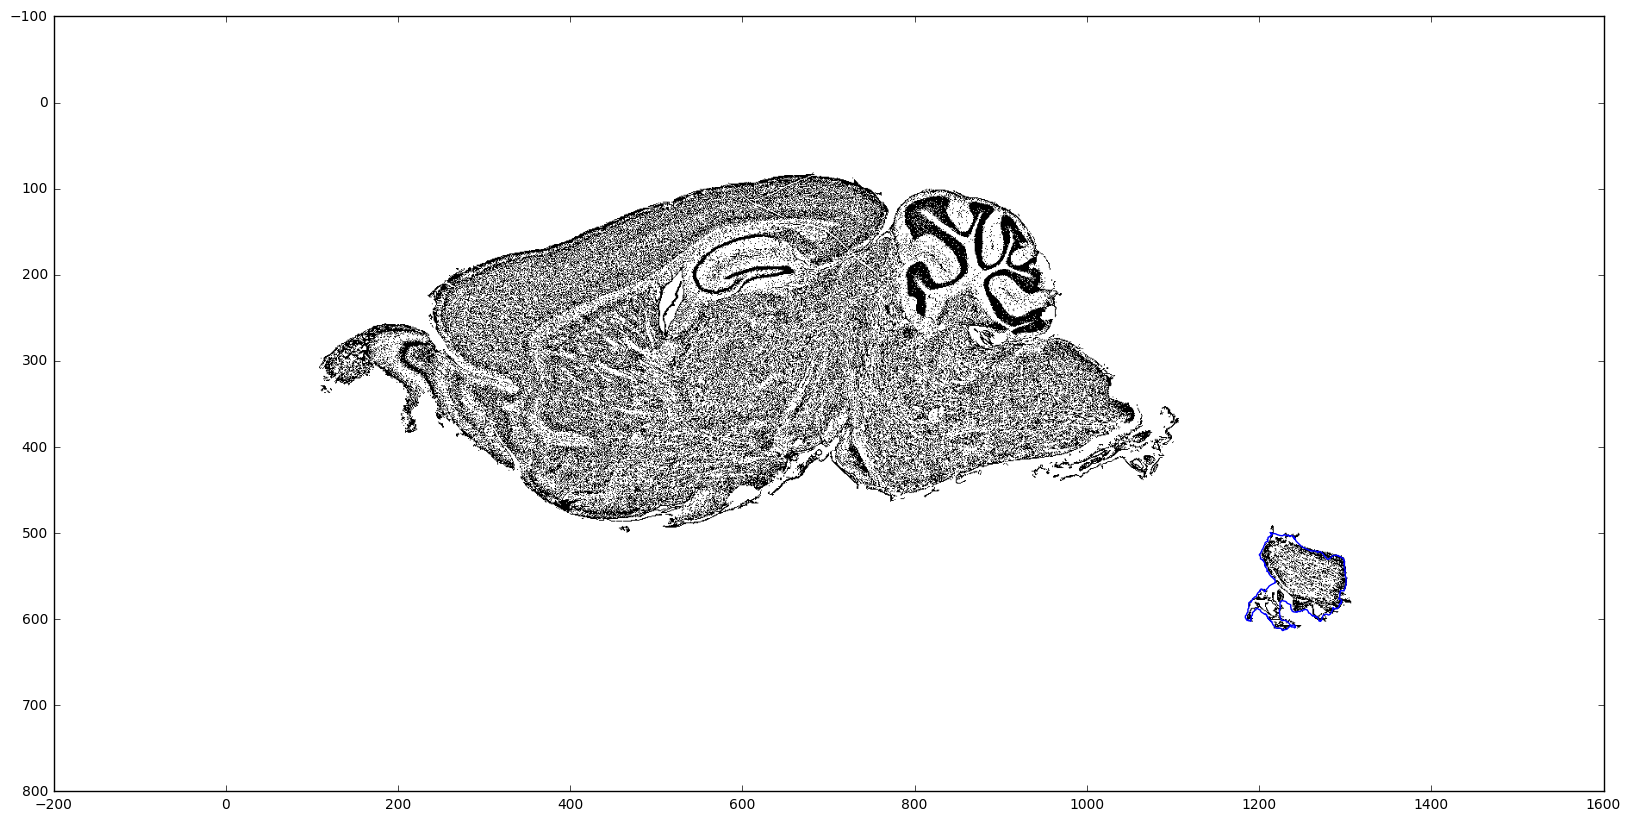

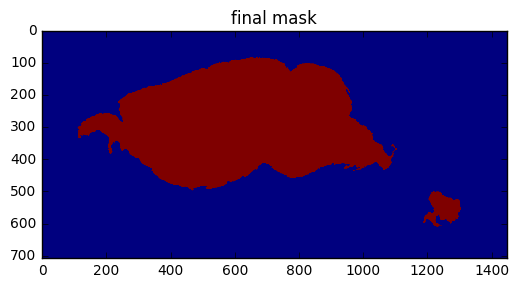

In [41]:
final_masks = []

for init_cnt in init_contours:

    snake = active_contour(img_adap, init_cnt.astype(np.float),
                           alpha=1., beta=10., gamma=0.01,
                           w_line=0., w_edge=1.,
                           max_iterations=100)
    
    plt.figure(figsize=(20,20));
    plt.imshow(img_adap, cmap=plt.cm.gray);
    plt.plot(snake[:,0], snake[:,1]);
    plt.show();
    
    bg = np.zeros(img.shape[:2], bool)
    xys = points_inside_contour(snake.astype(np.int))
    bg[np.minimum(xys[:,1], bg.shape[0]-1), np.minimum(xys[:,0], bg.shape[1]-1)] = 1
    
#     plt.imshow(bg);
#     plt.title('bg');
#     plt.show();

    final_mask = bg & entropy_mask
    final_masks.append(final_mask)

try:
    final_mask = np.any(final_masks, axis=0)
    
    plt.imshow(final_mask);
    plt.title('final mask');
    plt.show();
    
except Exception as e:
    sys.stderr.write(e.message + '\n')
    sys.stderr.write('%d, Mask error: %s\n' % (len(final_masks), fn))

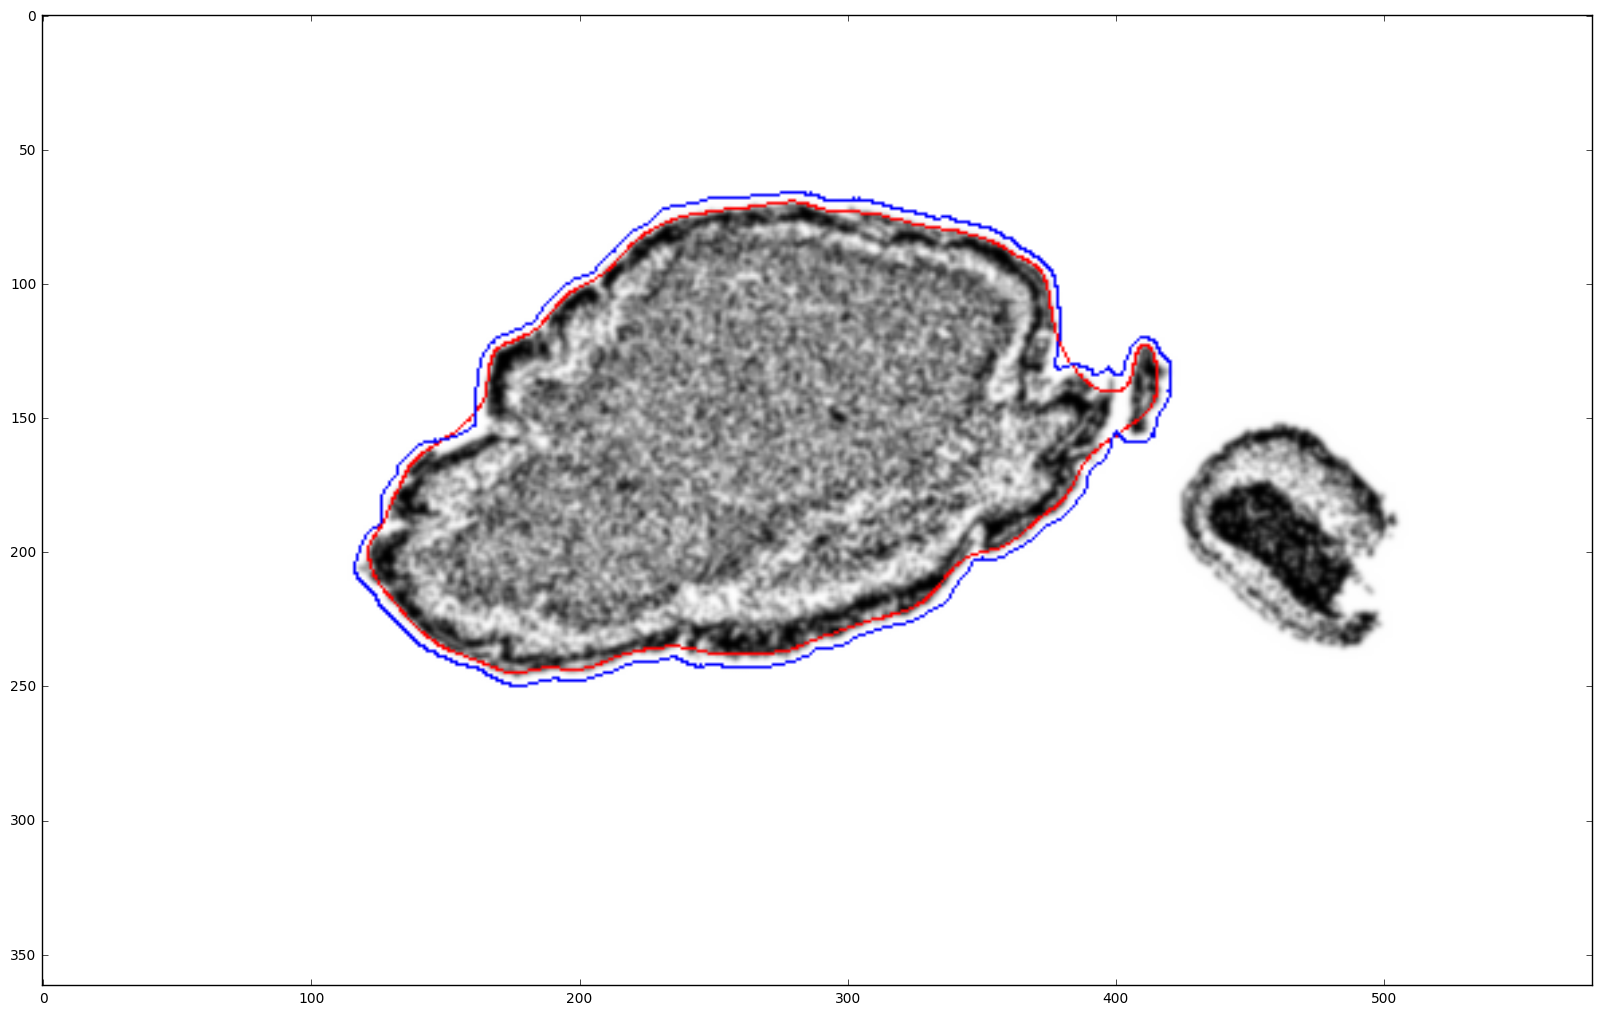

In [17]:
img_adap_gauss = gaussian(img_adap.astype(np.float), 1)

viz = gray2rgb((img_adap_gauss*255).astype(np.uint8))
# viz = gray2rgb(img_adap.astype(np.uint8)*255)

init_cnt = init_contours[0]

snake = active_contour(img_adap_gauss, init_cnt.astype(np.float),
                       alpha=1., beta=1000., gamma=1.,
                       w_line=0., w_edge=10.,
                       max_iterations=1000)

cv2.polylines(viz, [snake.astype(np.int)], True, (255,0,0), 1)
cv2.polylines(viz, [init_cnt.astype(np.int)], True, (0,0,255), 1)

plt.figure(figsize=(20,20));
plt.imshow(viz);

In [42]:
output_dir = '/home/yuncong/CSHL_data_processed/%(stack)s/%(stack)s_mask_unsorted/' % dict(stack=stack)

In [43]:
mask_fn = os.path.join(output_dir, '%(fn)s_mask.png' % dict(fn=fn))
imsave(mask_fn, img_as_ubyte(final_mask))

In [ ]:
xmin, xmax, ymin, ymax = bbox_2d(img2)

img3 = img2[ymin-10:ymax+10, xmin-10:xmax+10].copy()

h, w = img3.shape[:2]
init = np.r_[np.c_[np.arange(w), np.zeros((w,))], 
             np.c_[w*np.ones((h,)), np.arange(h)], 
             np.c_[np.arange(w, 0, -1), h*np.ones((w,))], 
             np.c_[np.zeros((h,)), np.arange(h, 0, -1)]]

In [ ]:
sys.path.append('/home/yuncong/Brain/preprocess/morphsnakes')
import morphsnakes
from collections import deque
from registration_utilities import *

scoremap_viz = img_as_ubyte(img3.copy())

In [ ]:
init_levelset = np.zeros((h, w))
init_levelset[10:-10, 10:-10] = 1.
# init_levelset[inside_points_inroi[:,1], inside_points_inroi[:,0]] = 1.

t = time.time()

msnake = morphsnakes.MorphACWE(img3.astype(np.float), smoothing=3, lambda1=1., lambda2=1.)

msnake.levelset = init_levelset.copy()

dq = deque([None, None])
for i in range(1000): 

    # at stable stage, the levelset (thus contour) will oscilate, 
    # so instead of comparing to previous levelset, must compare to the one before the previous
    oneBefore_levelset = dq.popleft()

    if i > 10:
#                 print np.count_nonzero(msnake.levelset - oneBefore_levelset)
        if np.count_nonzero(msnake.levelset - oneBefore_levelset) < 3:
            break

    dq.append(msnake.levelset)

    msnake.step()

    if i % 50 == 0:
        show_levelset(msnake.levelset, scoremap_viz, 'iteration %d' % i)

show_levelset(msnake.levelset, scoremap_viz, 'iteration %d' % i)

# # in the final levelset, inside could be 0. or 1., hard to say        
# edge_arr = np.r_[msnake.levelset[:,0], msnake.levelset[:,-1], msnake.levelset[0], msnake.levelset[-1]]        
# pos_edge_num = np.count_nonzero(edge_arr)
# bool_arr = msnake.levelset.astype(np.bool)

# if pos_edge_num < len(edge_arr) - pos_edge_num:
#     # inside is 1.
#     mean_inside_score = scoremap_roi[bool_arr].mean()
# else:
#     # inside is 0.
#     mean_inside_score = scoremap_roi[~bool_arr].mean()
#     msnake.levelset = 1. - msnake.levelset

# # after this, all inside pixels have value 1.

# print 'mean inside score:', mean_inside_score
# print 'area:', np.count_nonzero(bool_arr)
# print 'snake iteration:', i

# if mean_inside_score < .3:
#     continue

# sys.stderr.write('snake completes %f s\n' % (time.time() - t))

# #         m = binary_closing(msnake.levelset, disk(20))
# #         plt.figure(figsize=(10,10));
# #         plt.imshow(m);
# #         plt.show();

# t = time.time()

# new_cnts = find_contours(msnake.levelset, 0.5)
# new_cnts = [c[:, ::-1] for c in new_cnts]

In [ ]:
from skimage.segmentation import active_contour
cnt = active_contour(img3, init.astype(np.float), alpha=.1, beta=.001, gamma=0.001, w_edge=10.)

img4 = img3.copy()
# img4[cnt[:,1].astype(np.int), cnt[:,0].astype(np.int)] = 1.
cv2.polylines(img4, [cnt.astype(np.int)], True, (1.,1.,1.))
plt.figure(figsize=(20,20));
plt.imshow(img4, cmap=plt.cm.gray);

In [ ]:
plt.imshow(e);
plt.colorbar();